In [1]:
import face_recognition
import os
import cv2
import re
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from typing import Tuple

# Extracción

In [2]:
main_dir = './dataset'

In [3]:
def extract_faces() -> None:
    for image_filename in tqdm(os.listdir(f"{main_dir}/01 - raw/train/")):
        image_face = face_recognition.load_image_file(f"{main_dir}/01 - raw/train/{image_filename}")
        face_locations = face_recognition.face_locations(image_face)

        for idx, item in enumerate(face_locations):
            # Extraemos coordenadas
            left = item[3] #x1
            top = item[0] #y1
            right = item[1] #x2
            bottom = item[2] #y2

            # Calculamos ancho y alto para cropear
            width = right-left
            height = bottom-top

            # Cargamos imagen en opencv
            img = cv2.imread(f"{main_dir}/01 - raw/train/{image_filename}")

            # Cropeamos la cara
            img_crop = img[top:top+height, left:left+width]

            # Guardamos la imagen de la cara
            base_filename = os.path.splitext(image_filename)[0]
            cv2.imwrite(f"{main_dir}/02 - processed/train/{base_filename}_{idx}.jpg", img_crop)

In [4]:
extract_faces()

  0%|          | 0/6 [00:00<?, ?it/s]

# Entrenamiento

In [5]:
def get_train_encodings() -> Tuple[list, list]:
    train_encodings = []
    train_labels = []

    for image_filename in tqdm(os.listdir(f"{main_dir}/02 - processed/train/")):
        face_train = face_recognition.load_image_file(f"{main_dir}/02 - processed/train/{image_filename}")
        face_encoding = face_recognition.face_encodings(face_train)[0]
        train_encodings.append(face_encoding)
        train_labels.append(re.sub(r'\d', '', image_filename.split('_')[0]))
    
    return train_encodings, train_labels

In [6]:
train_encodings, train_labels = get_train_encodings()

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
set(train_labels)

{'alexis', 'andrew', 'franco', 'ian', 'lucio', 'nacho'}

# Reconocimiento

  0%|          | 0/8 [00:00<?, ?it/s]

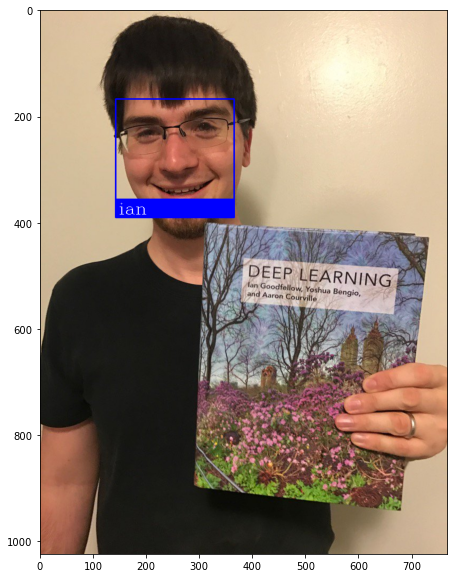

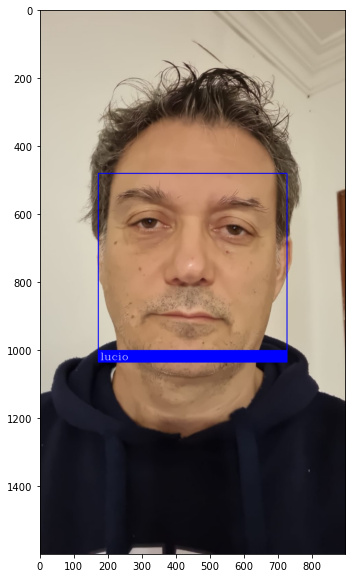

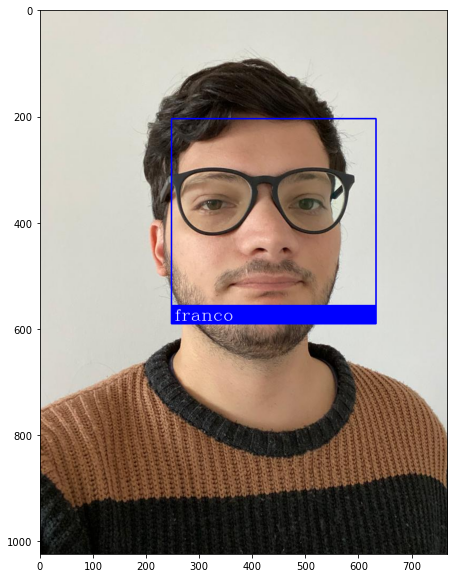

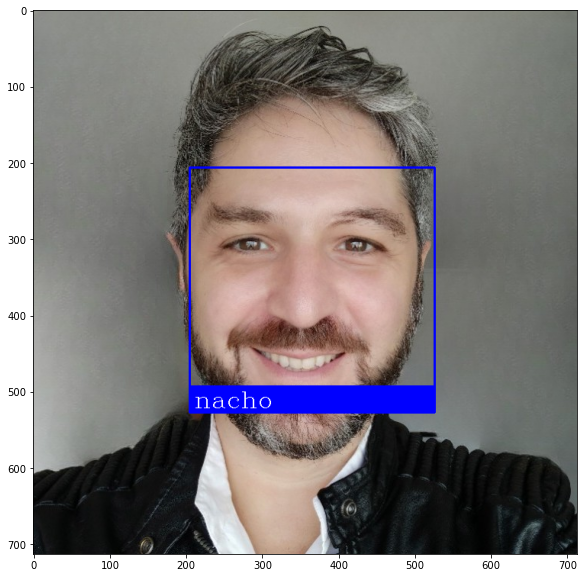

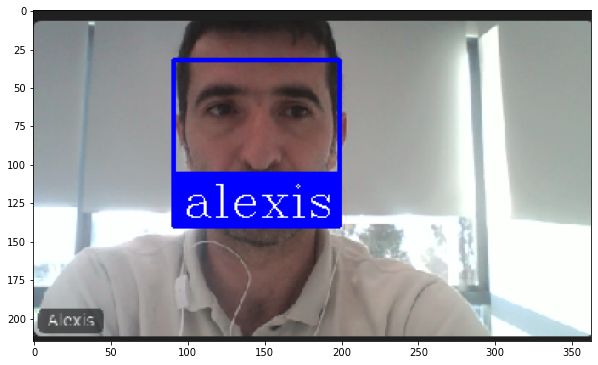

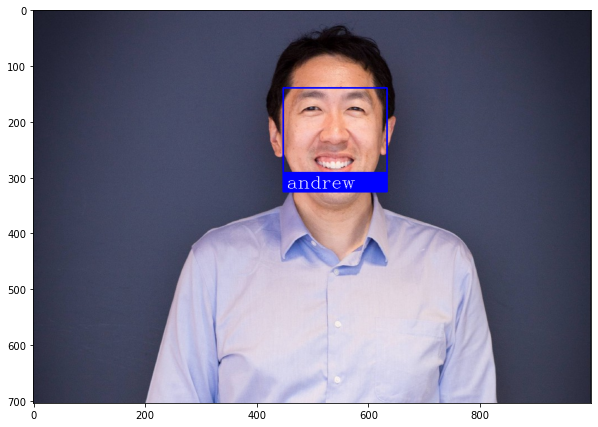

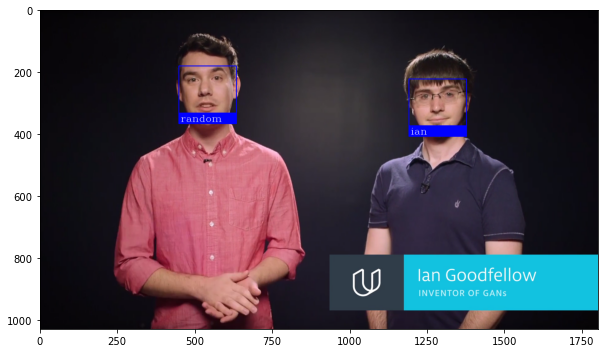

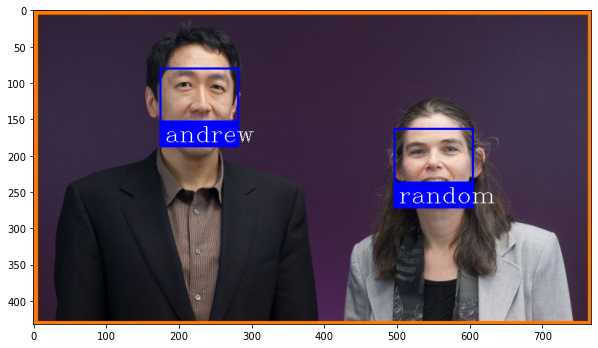

In [26]:
test_files = os.listdir(f"{main_dir}/01 - raw/test/")

for image_filename in tqdm(test_files):
    fig, ax = plt.subplots(figsize=(10, 10))

    image = cv2.imread(f"{main_dir}/01 - raw/test/{image_filename}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    face_encodings = face_recognition.face_encodings(image, face_locations)

    face_names = []
    # Iteramos en los encodings
    for face_encoding in face_encodings:
        face_distances = face_recognition.face_distance(train_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if face_distances[best_match_index] < 0.6:
            face_names.append(train_labels[best_match_index])
        else:
            face_names.append("random")
    
    # Este for lo que hace es escribir en cada cara un rectangulo con su nombre
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)
        cv2.rectangle(image, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_COMPLEX
        cv2.putText(image, name, (left + 6, bottom - 6), font, 1, (255, 255, 255), 1)
    
    ax.imshow(image)
    plt.show()